### Example of SODF system excited by artificial ground motion
- using MASS21 and COMBIN14 elements

- Generate artificial ground motion 

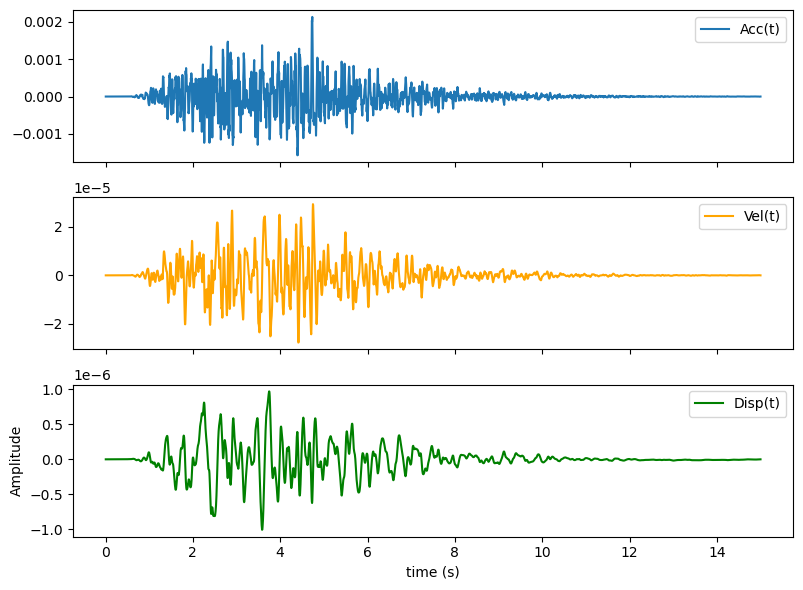

In [1]:
import matlab.engine
import numpy as np
import matplotlib.pyplot as plt

# Start the matlab engine
eng = matlab.engine.start_matlab()
# Link to the dir of matlab function
eng.cd(r'C:\Users\v196m\Desktop\master_project\Masterarbeit\GroundMotion\GroundMotionGeneration', nargout=0)
#s = eng.genpath('\BaselineCorrection')
#eng.addpath(s, nargout=0)
#eng.cd(r'C:\Users\v196m\Desktop\master_project\Masterarbeit\GroundMotion\GroundMotionGeneration\BaselineCorrection', nargout=0)
# Parameter of GM setting
Start_Time = 0.005
End_time = 15.005
Time_interval = 0.005
Time =  np.arange(Start_Time, End_time, Time_interval)

Time_info = np.array([0.5,	4.51602635361311,	6.51382766164269,	10.8203132545630])
FRF_info  = np.array([85.634147247517, 0.364521248606246, 0.213591303771144])
AriasIntensity = 0.0000508679639647511

# Generate ground motion
time,acc,vel,disp = eng.fns_generateGM_Params(5,Time,100,"Hu_S0", FRF_info, Time_info, AriasIntensity,1, nargout=4)
acc_signal = np.column_stack((time, acc))
vel_signal = np.column_stack((time, vel))
disp_signal = np.column_stack((time, disp))

time_interval_transient = 0.005
n_time=int(((End_time-Start_Time)/time_interval_transient)+1)


# Create a figure and three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 6))

# Plot on the first subplot
ax1.plot(np.array(time), np.array(acc), label='Acc(t)')
#ax1.set_ylabel('Amplitude')
ax1.legend()

# Plot on the second subplot
ax2.plot(np.array(time), np.array(vel), label='Vel(t)', color='orange')
#ax2.set_ylabel('Amplitude')
ax2.legend()

# Plot on the third subplot
ax3.plot(np.array(time), np.array(disp), label='Disp(t)', color='green')
ax3.set_xlabel('time (s)')
ax3.set_ylabel('Amplitude')
ax3.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()



- ANSYS SDOF system

In [2]:
from ansys.mapdl.core import launch_mapdl
mapdl = launch_mapdl(nproc=4)

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...


In [3]:
mapdl.prep7()
mapdl.units("SI")  # SI - International system (m, kg, s, K).


# Create Node
mapdl.n(1,"0","0","0")
mapdl.n(2,"0","0","10")

# Define mass21 element 
mapdl.et(1, "MASS21", kop3=2)
mapdl.type(1)
mapdl.real(1)
mapdl.r(1,100)
mapdl.e(2)


mapdl.et(2, "COMBIN14", kop2=3)
mapdl.type(2)
mapdl.real(2)
k = (4*np.pi**2)*10000
mapdl.r(2,k,1000)
mapdl.e(1,2)


mapdl.nsel("ALL")
mapdl.allsel()
mapdl.nummrg("ALL")

mapdl.load_table("ACC_input", acc_signal ,"TIME")
mapdl.load_table("VEL_input", vel_signal ,"TIME")
mapdl.load_table("DISP_input", disp_signal ,"TIME")


#mapdl.eplot(
#    vtk=True,
#    show_node_numbering=True,
#    cpos="yz",
#    show_edges=True,
#    show_axes=True,
#    line_width=2,
#)



In [56]:
#mapdl.run("/SOLU")
#mapdl.antype(4)  # transient analysis
#mapdl.trnopt("FULL")  # full transient analysis
#
#mapdl.outres("ALL","NONE")	
#mapdl.outres("NSOL","1")
#mapdl.outres("EPFL")
#mapdl.outres("ESOL")
#mapdl.outres("RSOL")
#
#mapdl.eqslv("SPARSE")  # use sparse solver
#
#mapdl.dmprat("0.05")
#
#count = 0
#for i_time in range(n_time-1):
#    tval = (i_time+1)*time_interval_transient
#    mapdl.time(tval)
#    #print(mapdl.time("tval"))
#    mapdl.d("1","ACCZ","%ACC_input%")
#
#    mapdl.nsubst("1")
#    mapdl.allsel()
#    mapdl.solve()
#
#    if i_time == int(count*(n_time/20)):
#        print("SOLVING TRANSIENT ANAYLSIS: ",5*count, " %")
#        count = count + 1
#
#mapdl.exit()


- Testing another solving method

In [4]:
mapdl.run("/SOLU")
mapdl.antype(4)  # transient analysis
mapdl.trnopt("FULL")  # full transient analysis

mapdl.outres("ALL","NONE")	
mapdl.outres("NSOL","1")
#mapdl.outres("EPFL")
#mapdl.outres("ESOL")
#mapdl.outres("RSOL")
mapdl.outres("V","1")
mapdl.outres("A","1")

# Time stepping
end_time = End_time
mapdl.time(end_time)  # end time for load step
mapdl.autots("ON")  # use automatic time stepping
#mapdl.parameters["tsres_time"] = Time
#mapdl.tsres("%tsres_time%")

# setup where the subset time is 10 seconds, time
mapdl.deltim(0.001, 0.0005, 0.0015)  # substep size (seconds)
#                          -- minimum value shorter than smallest
#                            time change in the table arrays below

mapdl.eqslv("SPARSE")  # use sparse solver
mapdl.dmprat("0.05")
#mapdl.d("1","ACCZ","%ACC_input%")
mapdl.d("1","UZ","%DISP_input%")

mapdl.solve()

*** NOTE ***                            CP =       2.359   TIME= 20:30:37
 The automatic domain decomposition logic has selected the MESH domain   
 decomposition method with 4 processes per solution.                     

 *****  ANSYS SOLVE    COMMAND  *****

 *** NOTE ***                            CP =       2.359   TIME= 20:30:37
 There is no title defined for this analysis.                            

 *** WARNING ***                         CP =       2.359   TIME= 20:30:37
 Nodes I and J of element 2 ( COMBIN14 ) are not coincident.             

 *** NOTE ***                            CP =       2.359   TIME= 20:30:37
 The model data was checked and warning messages were found.             
  Please review output or errors file (                                  
 C:\Users\v196m\AppData\Local\Temp\ansys_njwbbixltr\file0.err ) for      
 these warning messages.                                                 

 *** ANSYS - ENGINEERING ANALYSIS SYSTEM  RELEASE 2021 R2         

- Postprossesor

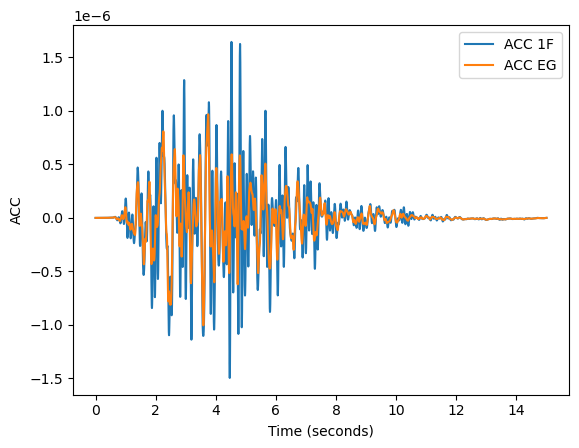

In [6]:
mapdl.post26()
acc_z_EG = mapdl.nsol("2","1","U","Z")
acc_z_1F = mapdl.nsol("3","2","U","Z")


time_values = mapdl.post_processing.time_values


plt.plot(time_values,acc_z_1F, label="ACC 1F")
plt.plot(time_values,acc_z_EG, label="ACC EG")
#plt.plot(time_values, label="ACC time")
plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("ACC")
plt.show()


In [7]:

mapdl.exit()